In [1]:
import os
import torch
from functools import partial
from torch import nn
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from IPython import display
import numpy as np
import torch.nn.functional as F
from torch.distributions import Beta
from tqdm.auto import tqdm
import functools
from einops import rearrange, repeat
from scipy.linalg import sqrtm

from scipy.stats import gaussian_kde

import sys
sys.path.insert(0, '..')

from models.pfgmpp import EDMLoss, edm_sampler, StackedRandomGenerator
from models.unets import PFGMPPUNet
from likelihood import get_likelihood_fn
from models.embeddings import PositionalEmbedding
from dataloaders.loaders import DarcyLoader, ModDarcyLoader
from physics.operators import DarcyFlow
from utils import create_patch_mask, create_scatter_mask

/home/ylzhuang/anaconda3/envs/sde/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


In [3]:
# For FUll condition
seed_everything(42)

model_params = {
    "dim": 64,
    "in_channels": 2,
    "out_channels": 2,
    "cond_size": 1,
    "kernel_size": 3,
    "padding": 1,
    "model_channels": 256,
    "channel_mult": [1, 2],
    "channel_mult_emb": 2,
    "num_blocks": 1,
    "dropout": 0.0,
    "dim_mult_time": 1,
    "cond_drop_prob": 0.0,
    "adaptive_scale": True,
    "skip_scale": 1,
    "groups": 8,
    "attention": True, #attention
    "num_heads": 1,   #attention
    "pfgmpp": False,
    "D": 2048,
    "use_fp16": False,
    "sigma_min": 0,
    "sigma_max": 1e10,
    "sigma_data": 0.5,
    "model_type": 'CFGUNet'
}

sampler_kwargs = {
    "num_steps": 18,
    "sigma_min": 0.002,
    "sigma_max": 80,
    "rho": 7,
    "S_churn": 0,
    "S_min": 0,
    "S_max": 1e10,
    "S_noise": 0,
    "pfgmpp": False,
    "deterministic": True,
}


opr_config= {
    "dx": 0.015625,
    "eps": 1e-8,
    "mu_p": 0.0,
    "sigma_p": 0.08232874,
    "mu_k": 1.14906847,
    "sigma_k": 7.81547992
}

operator = DarcyFlow(**opr_config)

def compute_mse_for_dataloaders(data_module, model, sampler_kwargs, device='cpu', operator=operator):
    loaders = {
        'train': data_module.train_dataloader(),
        'val': data_module.val_dataloader(),
        'test': data_module.test_dataloader()
    }
    mse_scores = {}
    residual_scores = {}
    model.to(device)
    model.eval()
    
    with torch.no_grad():  # Ensure no gradients are computed to save memory and computations
        for phase, loader in loaders.items():
            total_mse = 0.0
            total_samples = 0
            squared_residual_sum = 0
            
            for batch in tqdm(loader, desc=f"Processing {phase} data"):
                # Assuming each batch contains inputs and targets
                inputs, cond = batch
                inputs, cond = inputs.to(device), cond.to(device)
                
                rnd = StackedRandomGenerator(device, range(inputs.shape[0]))
                latents = rnd.randn(inputs.shape, device=device)
                samples, _ = edm_sampler(model, latents=latents, class_labels=cond, **sampler_kwargs)

                p = samples[:, 0, :, :]*operator.sigma_p + operator.mu_p
                k = samples[:, 1, :, :]*operator.sigma_k + operator.mu_k
                residual, _, _, _, _, _, _ = operator.r_diff(p, k)
                squared_residual_sum += torch.sum(residual**2)
                
                # Compute MSE loss for the current batch
                mse = nn.functional.mse_loss(samples, inputs)
                
                # Accumulate MSE and sample count
                total_mse += mse.item() * inputs.size(0)  # Multiply by batch size
                total_samples += inputs.size(0)
            
            # Compute mean MSE for the current phase
            mse_scores[phase] = total_mse / total_samples
            residual_scores[phase] = squared_residual_sum / total_samples
    
    return mse_scores, residual_scores


dataloader = ModDarcyLoader("/home/csjacobs/git/diffusionPDE/datasets/Darcy_n16",
                                   batch_size=192, num_workers=8)
dataloader.setup(stage='test')
dataloader.setup(stage='fit')

In [4]:
model = PFGMPPUNet(**model_params)
# Load the checkpoint
#ckpt_path = '../test_log/inpaint/2024-02-17T09-55-39_edm_cfg/checkpoints/best_val.ckpt' #CFG
ckpt_path = '../test_log/inpaint/2024-02-16T02-46-56_edm_revised_attn/checkpoints/best_val.ckpt' #attn
if os.path.exists(ckpt_path):
    checkpoint = torch.load(ckpt_path)

    # Adjust the keys in the state dictionary
    state_dict = checkpoint['state_dict']
    new_state_dict = {key.replace('unet.', ''): value for key, value in state_dict.items()}

    # Load the adjusted state dictionary
    model.load_state_dict(new_state_dict)
else:
    print(f"Checkpoint not found at {ckpt_path}")

device = 'cuda:0'
model = model.to(device)

In [5]:
batch = next(iter(dataloader.test_dataloader()))
inputs, cond = batch
inputs = inputs[:16]
cond = cond[:16]
inputs, cond = inputs.to(device), cond.to(device)

with torch.no_grad():
    rnd = StackedRandomGenerator(device, range(inputs.shape[0]))
    latents = rnd.randn(inputs.shape, device=device)
    samples, _ = edm_sampler(model, latents=latents, class_labels=cond, **sampler_kwargs)

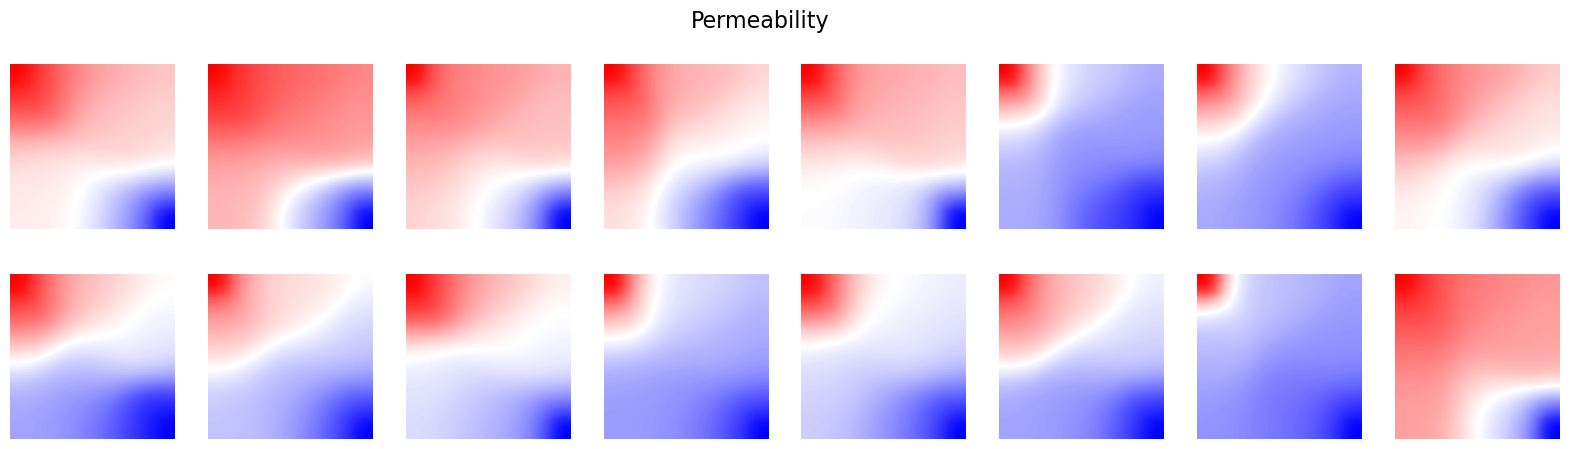

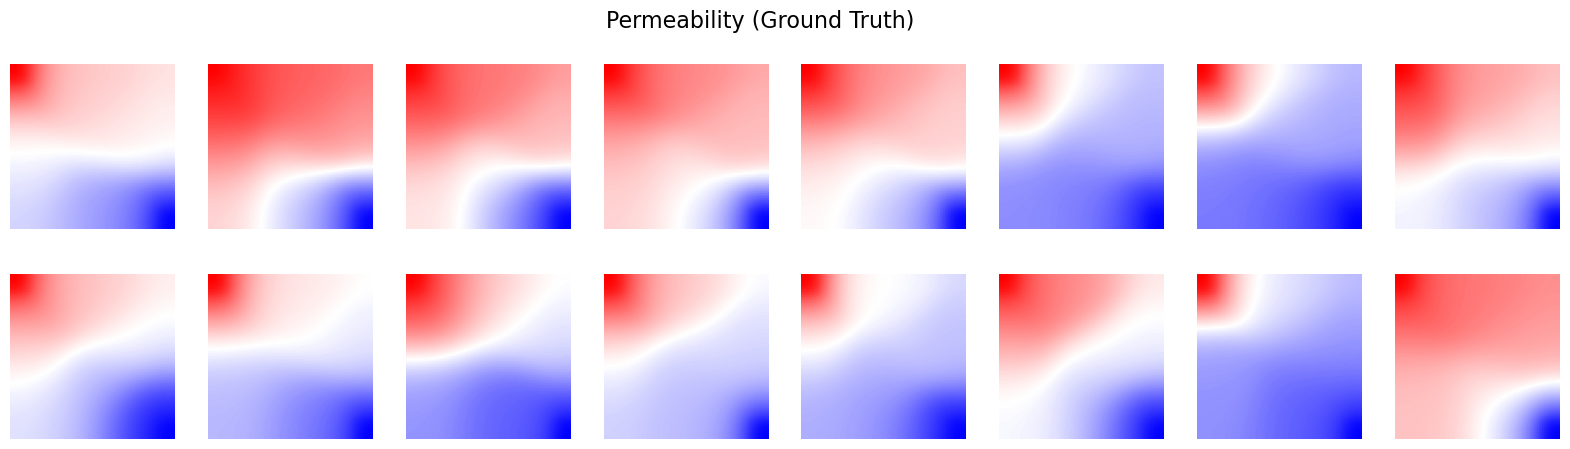

In [6]:
def plot_channel(samples, channel, title):
    aspect_ratio = int(samples.shape[0]/8)
    fig, axes = plt.subplots(aspect_ratio, 8, figsize=(20, int(aspect_ratio*2.5)))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes.flatten()):
        if i < samples.shape[0]:
            ax.imshow(samples[i, channel, :, :], cmap='bwr')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty plots

plot_channel(samples.detach().cpu(), 0, 'Permeability')
plot_channel(inputs.detach().cpu(), 0, 'Permeability (Ground Truth)')

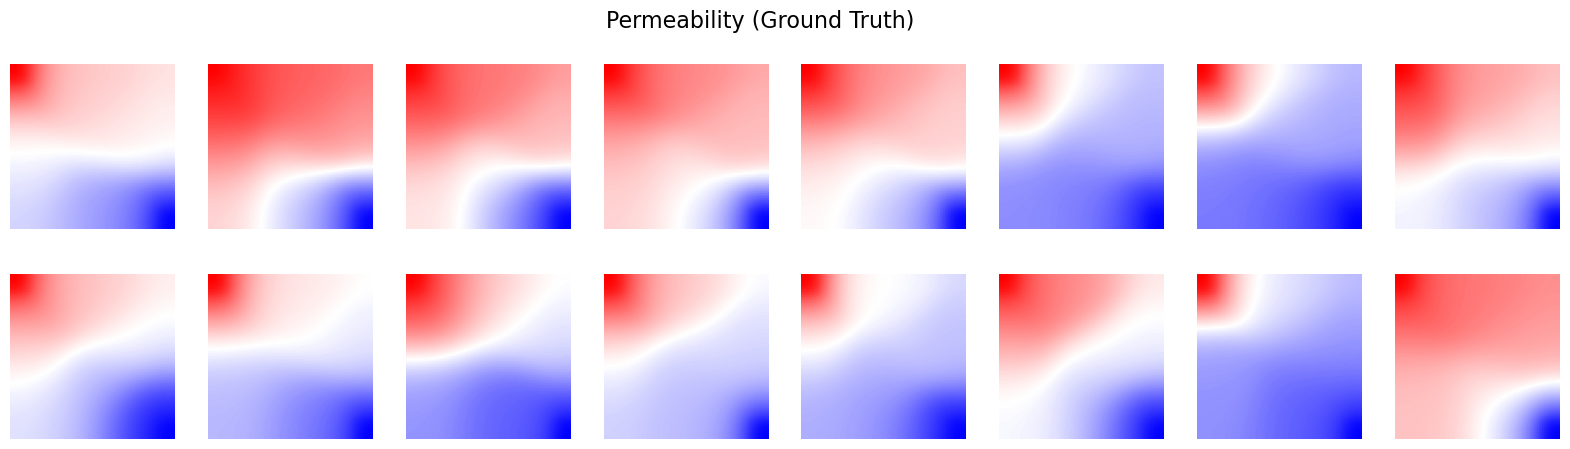

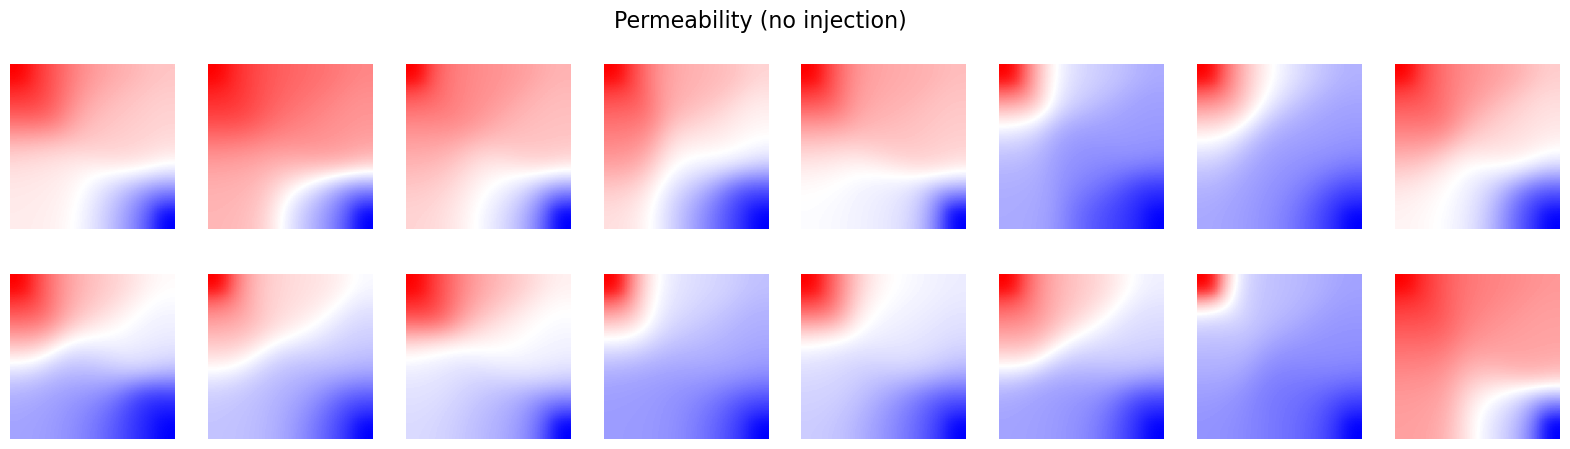

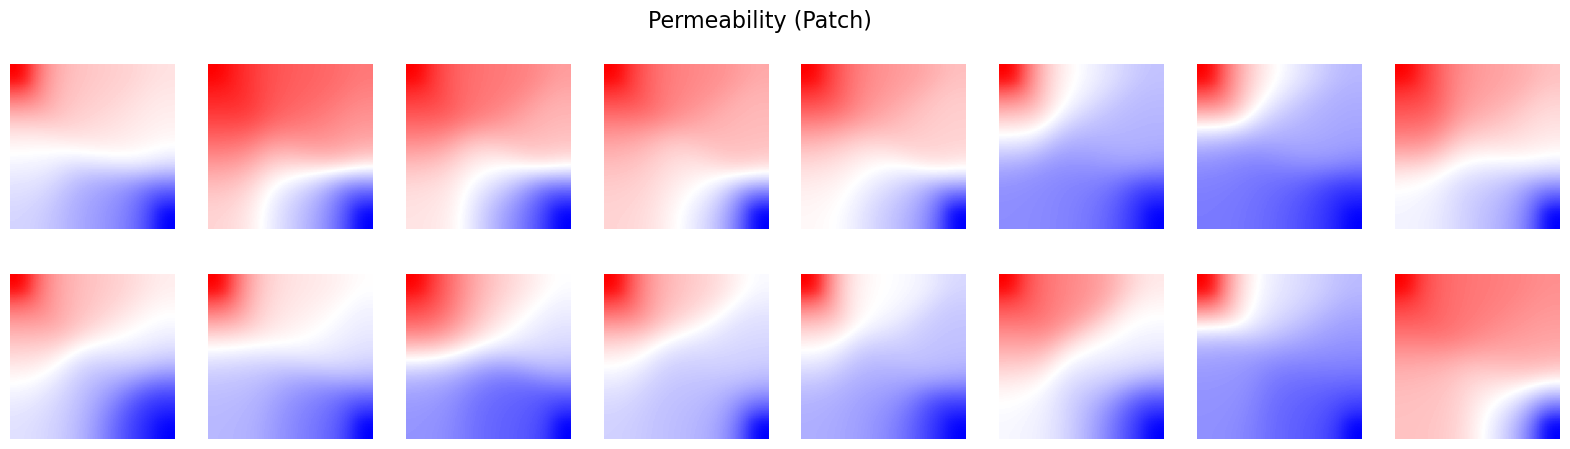

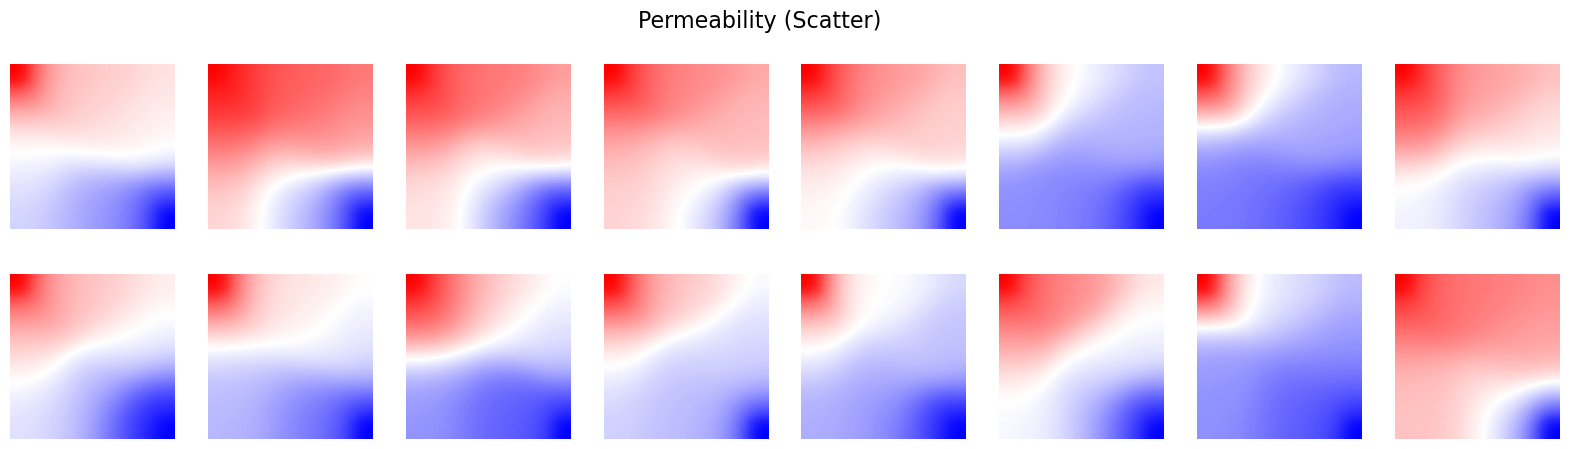

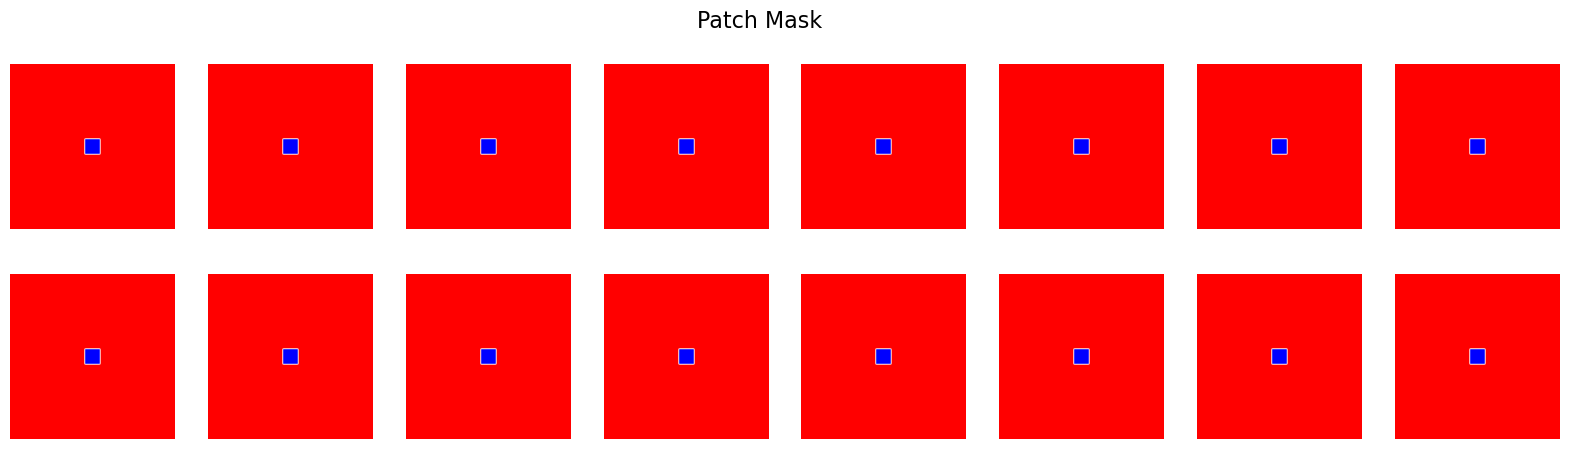

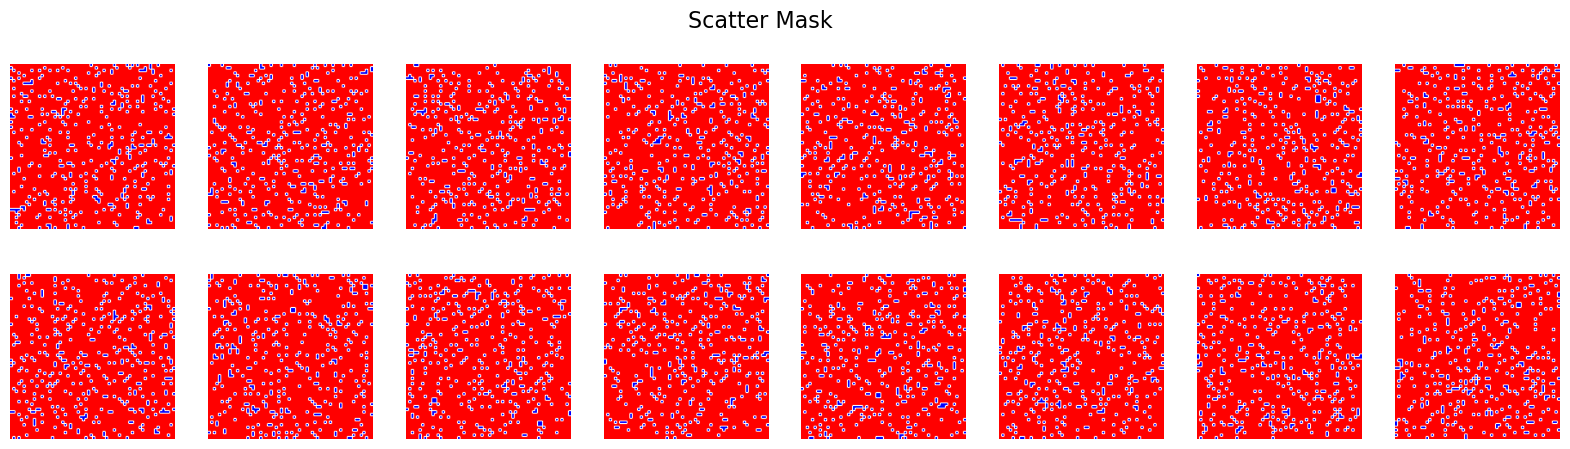

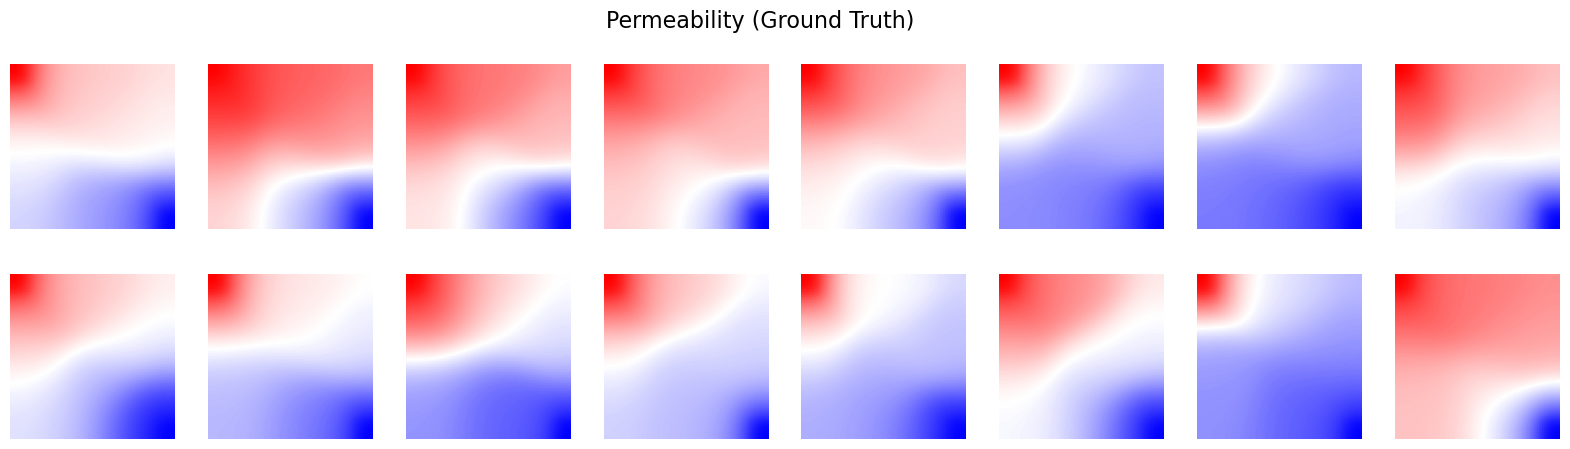

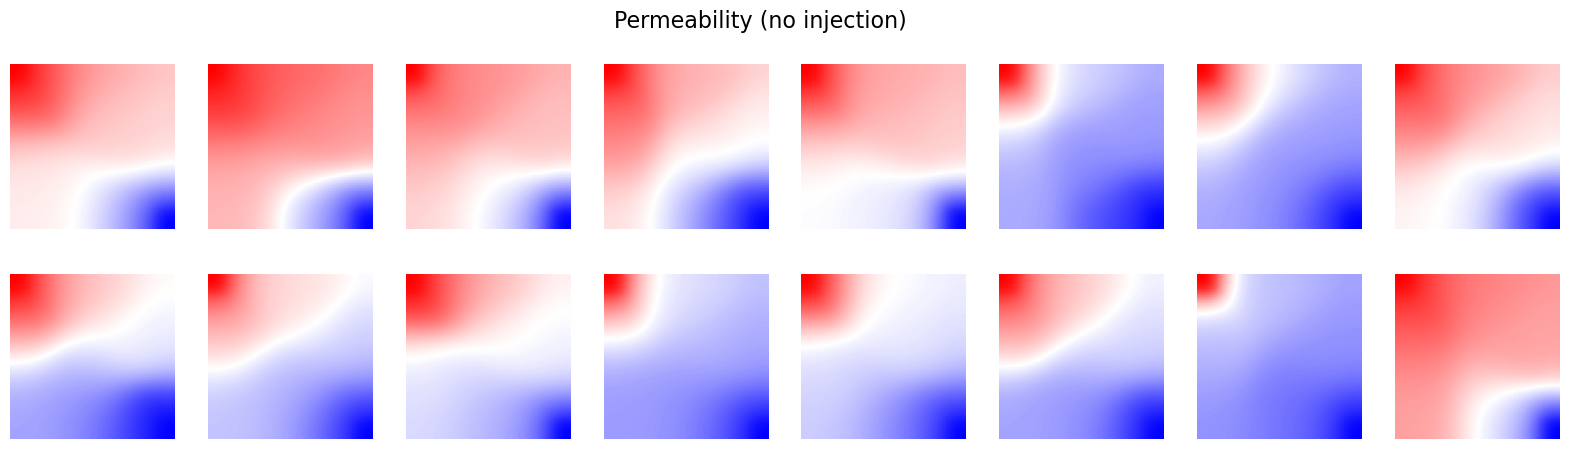

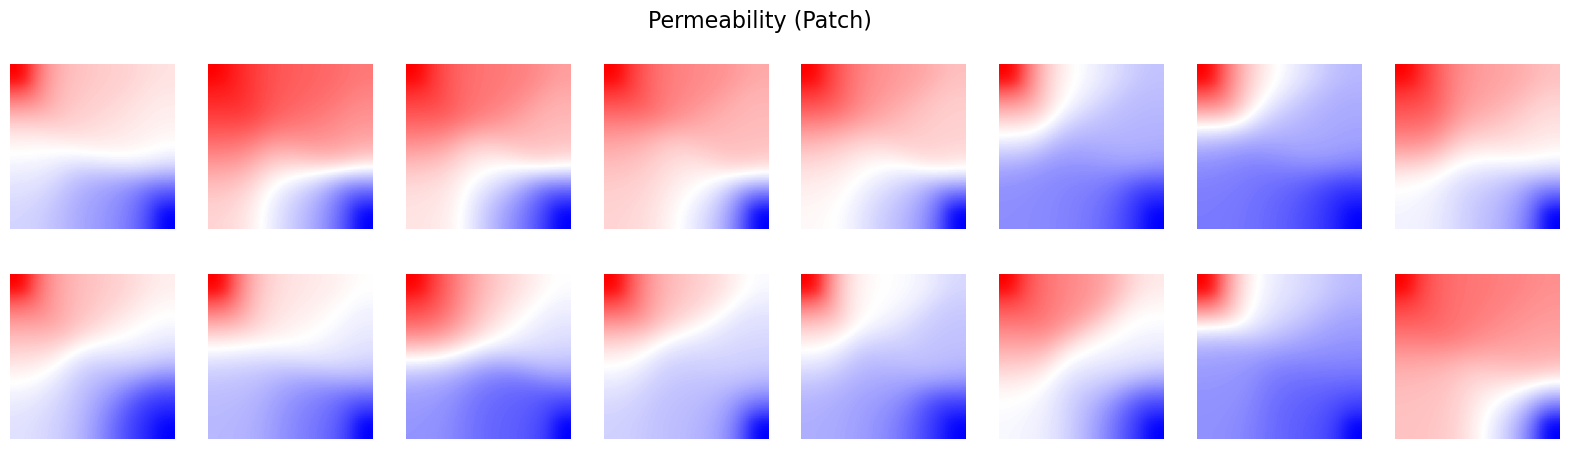

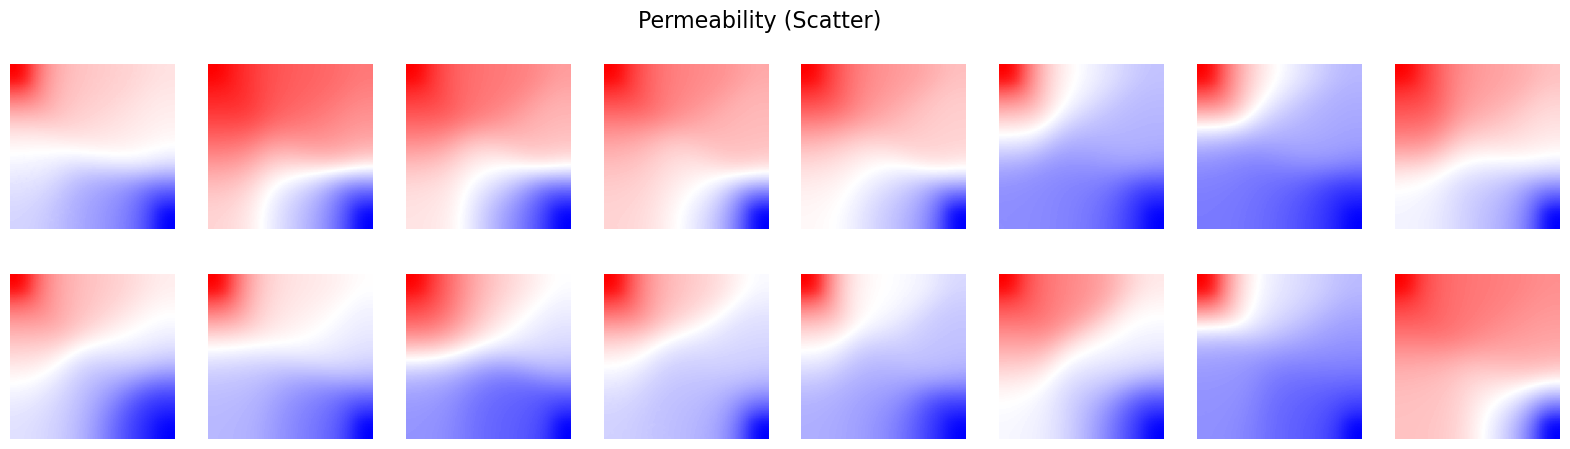

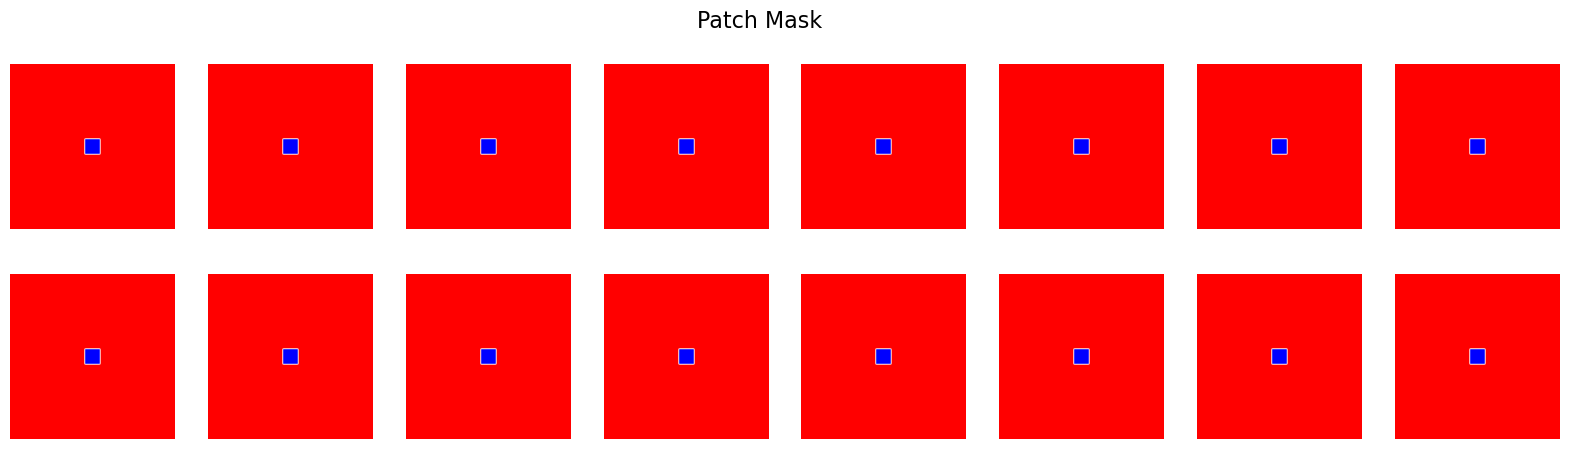

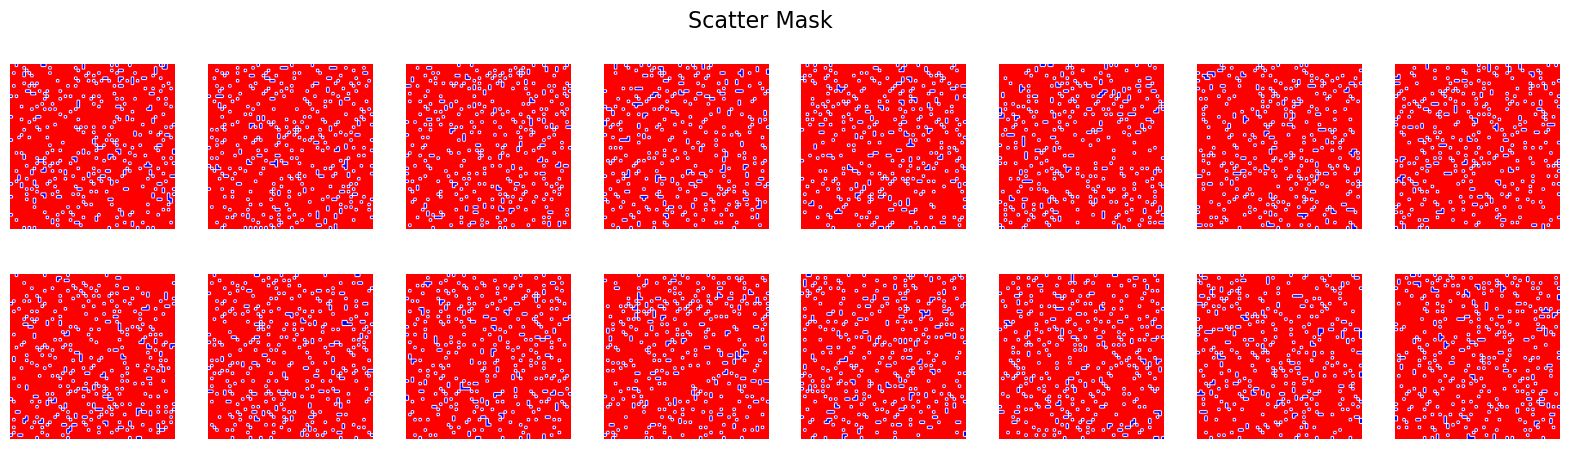

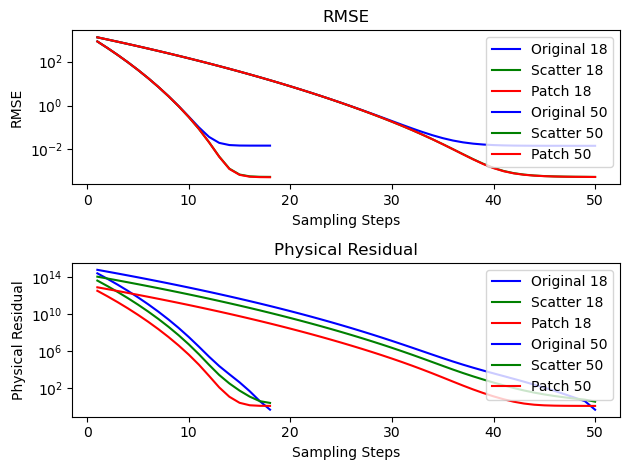

In [7]:
def eval_intermediate_residuals(intermediate, inputs, operator, mask=None, device='cpu'):
    # compute for physical residual, and the RMSE
    # exclude the affect of mask
    # intermediate: (Num sample step, B, C, H, W)
    # mask: (B, C, H, W)
    num_known = 0
    num_cells = inputs.shape[-1]*inputs.shape[-2]
    intermediate = intermediate.to(inputs.device)
    if mask is not None:
        # Calculate the number of known cells
        num_known = torch.sum(mask)/(mask.shape[0] * mask.shape[1]) # Assume all time step has same mask
    unknown_mse = torch.sum((intermediate - inputs)**2, axis=(1,2,3,4)) / ((num_cells - num_known) *inputs.shape[1]*inputs.shape[2])
    p_sample = intermediate[:,:,0,:,:]*operator.sigma_p + operator.mu_p
    k_sample = intermediate[:,:,1,:,:]*operator.sigma_k + operator.mu_k
    residual_field =[operator.r_diff(p_sample[i], k_sample[i])[0] for i in range(intermediate.shape[0])]
    residual_field = torch.stack(residual_field, dim=0)
    #residual_field,_,_,_,_,_,_ = operator.r_diff(p_sample[0], k_sample[0])
    unknown_physical_residual = torch.sum(residual_field**2, axis=(1,2,3)) / ((num_cells - num_known) *inputs.shape[1]*inputs.shape[2])
    return unknown_mse, unknown_physical_residual
    



def get_inpaint_residual(model, inputs, cond, num_steps, sampler_kwargs, operator, device='cpu', num_cycle=1):
    with torch.no_grad():
        scatter_mask = create_scatter_mask(inputs, channels=[0], ratio=0.9)
        patch_mask = create_patch_mask(inputs, channels=[0], ratio=0.1)
        rnd = StackedRandomGenerator(device, range(inputs.shape[0]))
        latents = rnd.randn(inputs.shape, device=device)
        for i in range(num_cycle):
            if i == 0:
                orig_samples, orig_intermediate = edm_sampler(model, latents=latents, class_labels=cond, num_steps = num_steps, **sampler_kwargs)
                patch_samples, patch_intermediate = edm_sampler(model, latents=latents, class_labels=cond, num_steps = num_steps, mask=patch_mask, known_latents=inputs, **sampler_kwargs)
                scatter_samples, scatter_intermediate = edm_sampler(model, latents=latents, class_labels=cond, num_steps = num_steps, mask=scatter_mask, known_latents=inputs, **sampler_kwargs)
            else:
                patch_samples, tmp_patch_intermediate = edm_sampler(model, latents=patch_samples, class_labels=cond, num_steps = num_steps, mask=patch_mask, known_latents=inputs, **sampler_kwargs)
                scatter_samples, tmp_scatter_intermediate = edm_sampler(model, latents=scatter_samples, class_labels=cond, num_steps = num_steps, mask=scatter_mask, known_latents=inputs, **sampler_kwargs)
                patch_intermediate = torch.cat([patch_intermediate, tmp_patch_intermediate], dim=0)
                scatter_intermediate = torch.cat([scatter_intermediate, tmp_scatter_intermediate], dim=0)

    plot_channel(inputs.detach().cpu(), 0, 'Permeability (Ground Truth)')
    plot_channel(orig_samples.detach().cpu(), 0, 'Permeability (no injection)')
    plot_channel(patch_samples.detach().cpu(), 0, 'Permeability (Patch)')
    plot_channel(scatter_samples.detach().cpu(), 0, 'Permeability (Scatter)')
    plot_channel(patch_mask.detach().cpu(), 0, 'Patch Mask')
    plot_channel(scatter_mask.detach().cpu(), 0, 'Scatter Mask')

    orig_mse, orig_phy_residual= eval_intermediate_residuals(orig_intermediate, inputs, operator, device=device)
    scatter_mse, scatter_phy_residual= eval_intermediate_residuals(scatter_intermediate, inputs, operator, scatter_mask, device=device)
    patch_mse, patch_phy_residual= eval_intermediate_residuals(patch_intermediate, inputs, operator, patch_mask, device=device)

    orig_mse = orig_mse.detach().cpu().numpy()
    scatter_mse = scatter_mse.detach().cpu().numpy()
    patch_mse = patch_mse.detach().cpu().numpy()

    orig_phy_residual = orig_phy_residual.detach().cpu().numpy()
    scatter_phy_residual = scatter_phy_residual.detach().cpu().numpy()
    patch_phy_residual = patch_phy_residual.detach().cpu().numpy()

    return orig_mse, scatter_mse, patch_mse, orig_phy_residual, scatter_phy_residual, patch_phy_residual

#num_steps = 50
num_steps_list = [18, 50]
sampler_kwargs = {
    #"num_steps": 18,
    "sigma_min": 0.002,
    "sigma_max": 80,
    "rho": 7,
    "S_churn": 0,
    "S_min": 0,
    "S_max": 1e10,
    "S_noise": 0,
    "pfgmpp": False,
    "deterministic": True,
}
# Assuming you have a list of sampling steps
sampling_steps = [list(range(1, i + 1)) for i in num_steps_list]
orig_mse_list = []
scatter_mse_list = []
patch_mse_list = []
orig_phy_residual_list = []
scatter_phy_residual_list = []
patch_phy_residual_list = []

for num_steps in num_steps_list:
    tmp_orig_mse, tmp_scatter_mse, tmp_patch_mse, tmp_orig_phy_residual, tmp_scatter_phy_residual, tmp_patch_phy_residual = get_inpaint_residual(
                                                                                    model, inputs, cond, num_steps, sampler_kwargs, operator, device, num_cycle=1)
    orig_mse_list.append(tmp_orig_mse)
    scatter_mse_list.append(tmp_scatter_mse)
    patch_mse_list.append(tmp_patch_mse)
    orig_phy_residual_list.append(tmp_orig_phy_residual)
    scatter_phy_residual_list.append(tmp_scatter_phy_residual)
    patch_phy_residual_list.append(tmp_patch_phy_residual)


fig, axs = plt.subplots(2)

# Plot RMSE
for i, num_steps in enumerate(num_steps_list):
    axs[0].plot(sampling_steps[i], orig_mse_list[i], color='b', label=f'Original {num_steps}')
    axs[0].plot(sampling_steps[i], scatter_mse_list[i], color='g', label=f'Scatter {num_steps}')
    axs[0].plot(sampling_steps[i], patch_mse_list[i], color='r', label=f'Patch {num_steps}')
    axs[0].set_title('RMSE')
    axs[0].set_xlabel('Sampling Steps')
    axs[0].set_ylabel('RMSE')
    axs[0].set_yscale('log')
    axs[0].legend()

# Plot Physical Residual
for i, num_steps in enumerate(num_steps_list):
    axs[1].plot(sampling_steps[i], orig_phy_residual_list[i], color='b', label=f'Original {num_steps}')
    axs[1].plot(sampling_steps[i], scatter_phy_residual_list[i], color='g', label=f'Scatter {num_steps}')
    axs[1].plot(sampling_steps[i], patch_phy_residual_list[i], color='r',label=f'Patch {num_steps}')
    axs[1].set_title('Physical Residual')
    axs[1].set_xlabel('Sampling Steps')
    axs[1].set_ylabel('Physical Residual')
    axs[1].set_yscale('log')
    axs[1].legend()

plt.tight_layout()
plt.show()

In [8]:
inputs.shape

torch.Size([16, 2, 64, 64])

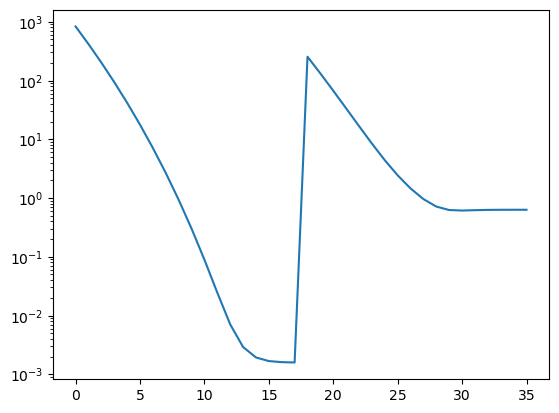

In [13]:
plt.plot(patch_mse_list[0], label='Patch 18')
plt.yscale('log')

In [9]:
print(patch_mask.shape, scatter_mask.shape)

NameError: name 'patch_mask' is not defined

In [ ]:
torch.sum(patch_mask, axis=(2,3))

tensor([[1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.],
        [1180.,    0.]], device='cuda:0')